# Importing data

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import os
import dask.dataframe as dd
import gc
import matplotlib.pyplot as plt
sns.set()

In [0]:
#connecting to kaggle and importing datasets
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

!kaggle competitions download -c talkingdata-adtracking-fraud-detection
!unzip train.csv.zip

Saving kaggle.json to kaggle.json
100% 1.21G/1.21G [00:13<00:00, 80.7MB/s]
100% 1.21G/1.21G [00:13<00:00, 96.3MB/s]
  0% 0.00/1.08M [00:00<?, ?B/s]
100% 1.08M/1.08M [00:00<00:00, 153MB/s]
 98% 162M/165M [00:03<00:00, 42.2MB/s]
100% 165M/165M [00:03<00:00, 50.6MB/s]
 88% 35.0M/39.8M [00:00<00:00, 91.4MB/s]
100% 39.8M/39.8M [00:00<00:00, 158MB/s] 
 98% 493M/504M [00:05<00:00, 106MB/s] 
100% 504M/504M [00:05<00:00, 94.7MB/s]
Archive:  train.csv.zip
  inflating: mnt/ssd/kaggle-talkingdata2/competition_files/train.csv  


In [0]:
#reading in train data
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32'
        }


train_all = dd.read_csv('mnt/ssd/kaggle-talkingdata2/competition_files/train.csv', dtype=dtypes)
display(train_all.shape)
display(train_all.columns)

(Delayed('int-45927549-8b57-444a-aa90-d8692bf92c08'), 8)

Index(['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time',
       'is_attributed'],
      dtype='object')

# Comparing time train vs test

Since it's very likely that time of day and date has a large influence on click counts and when apps are downloaded in general, want to take a look at how day and time are distributed in the test and train datasets

In [0]:
#creating day and hour 
train_all['hour'] = dd.to_datetime(train_all['click_time']).dt.hour.astype('uint8')
train_all['day'] = dd.to_datetime(train_all['click_time']).dt.day.astype('uint8')
day_dist=train_all['day'].value_counts()
hour_dist=train_all['hour'].value_counts()
day_dist=day_dist.compute()
hour_dist=hour_dist.compute()

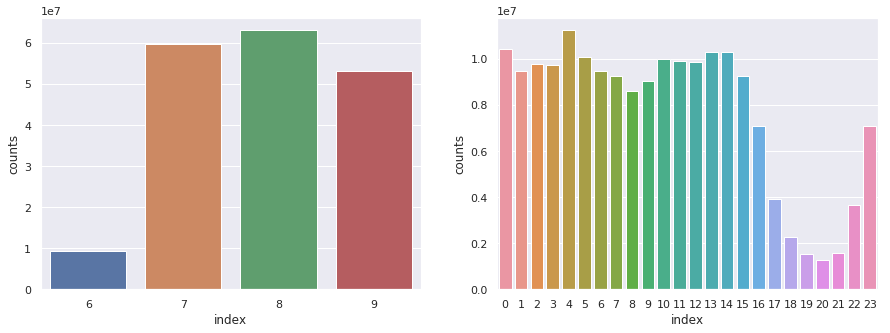

In [0]:
#day_dist=day_dist.reset_index(name='counts')
#our_dist=hour_dist.reset_index(name='counts')
#distribution of clicks by date and hour in the train set
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.barplot(x='index', y='counts', data=day_dist, ax=axs[0])
sns.barplot(x='index', y='counts', data=hour_dist, ax=axs[1])

The data in the training dataset comes from across four days of data. There seems to be a dip of clicks from 5pm-10pm in the dataset. This is in Greenwich time. China uses a single timezone  (GMT+8) which is 8 hours ahead of Greenwich time. So these dips are actually 1am-6am. 

In [0]:
del day_dist, hour_dist
gc.collect()

9269637

In [0]:
#looking at day and hour distributions in test dataset
dtypes = {
        'ip'            : 'uint32',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'click_id'      : 'uint32'
        }

#looking at date and time distributinos for data in the test set 
#creating day and hour 
test_all = dd.read_csv('test.csv', dtype=dtypes)

#creating hour and day features
test_all['hour'] = dd.to_datetime(test_all['click_time']).dt.hour.astype('uint8')
test_all['day'] = dd.to_datetime(test_all['click_time']).dt.day.astype('uint8')

#getting distribution of day and hour 
day_dist_test=test_all['day'].value_counts()
hour_dist_test=test_all['hour'].value_counts()

day_dist_test=day_dist_test.compute()
hour_dist_test=hour_dist_test.compute()

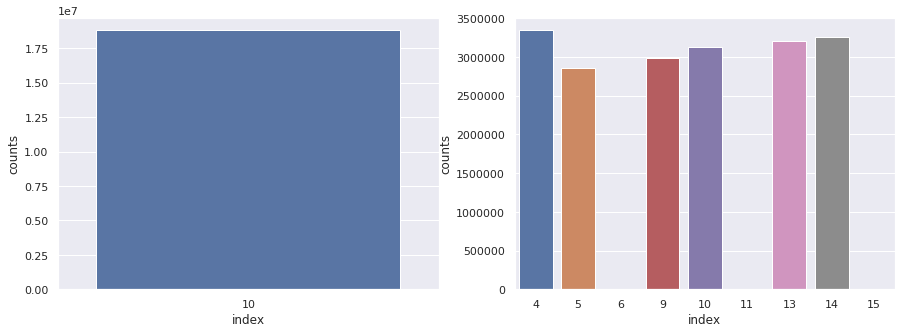

In [0]:
day_dist_test=day_dist_test.reset_index(name='counts')
hour_dist_test=hour_dist_test.reset_index(name='counts')
#distribution of clicks by date and hour in the test set
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
sns.barplot(x='index', y='counts', data=day_dist_test, ax=axs[0])
sns.barplot(x='index', y='counts', data=hour_dist_test, ax=axs[1])

So it looks like the test dataset is from day 10 and only select hours. In order for us to have a validation dataset as close as possible to the test dataset, we should use data from day 9 since it's the closest data we have to day 10. We should also use the same hours from the test dataset. So our validation data should be from day 9 and hours 4, 5,  9, 10, 13, 14

In [0]:
del day_dist, hour_dist 
gc.collect

# Variable click counts train vs test

In [0]:
#writing function to create value count df's for plotting
def create_value_counts(train_data, test_data, var):
  train = train_data[var].value_counts()
  test = test_data[var].value_counts()
  train = train.compute()
  test = test.compute()
  train = train.reset_index(name='counts').sort_values(ascending=False, by='counts')
  test = test.reset_index(name='counts').sort_values(ascending=False, by='counts')
  train.columns=[var, 'counts']
  test.columns=[var, 'counts']
  return(train[0:9], test[0:9], train, test)

def create_plots(train_10, test_10, train, test):
  fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 15))
  sns.barplot(x=train_10.iloc[:,0], y=train_10.iloc[:,1], data=train_10, ax=axs[0][0], order=train_10.iloc[:,0]).set_title('Train Dataset')
  sns.barplot(x=test_10.iloc[:,0], y=test_10.iloc[:,1], data=test_10, ax=axs[0][1], order=test_10.iloc[:,0]).set_title('Test Dataset')
  sns.scatterplot(x=train.iloc[:,0], y='counts', data=train, ax=axs[1][0]).set_title('Train Dataset')
  sns.scatterplot(x=test.iloc[:,0], y='counts', data=test, ax=axs[1][1]).set_title('Test Dataset')

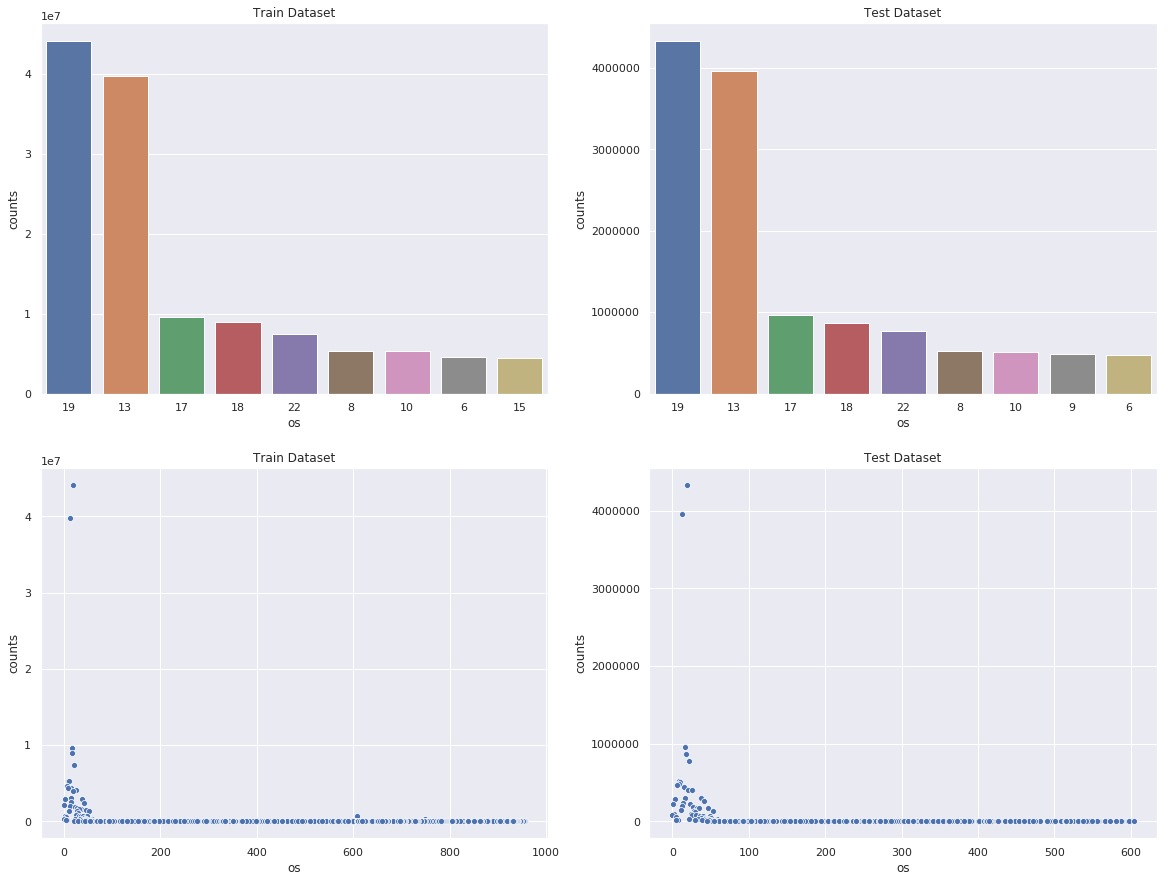

In [0]:
#creating plots for OS
os_train_10, os_test_10, os_train, os_test = create_value_counts(train_all, test_all, 'os')
create_plots(os_train_10, os_test_10, os_train, os_test)

os distributions are pretty similar between the train and test sets

In [0]:
del os_train_10, os_test_10, os_train, os_test 
gc.collect()

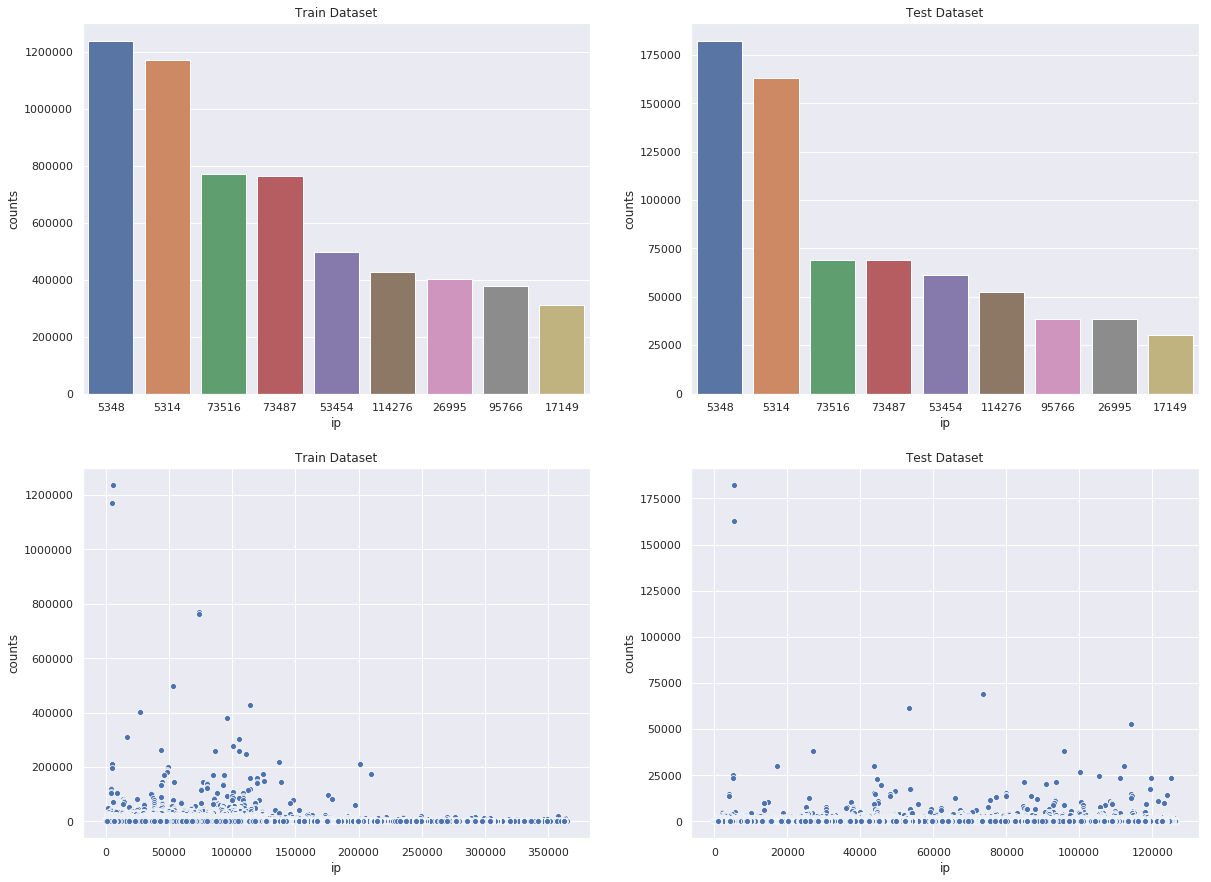

In [0]:
#creating plots for ip
ip_train_10, ip_test_10, ip_train, ip_test = create_value_counts(train_all, test_all, 'ip')
create_plots(ip_train_10, ip_test_10, ip_train, ip_test)

As was noted by several people in the discussions sections, the distributions of ip in the train and test sets look different. It looks like lower ip values were assigned to ip's with higher value counts whereas this pattern does not hold in the test dataset. 

In [0]:
del ip_train_10, ip_test_10, ip_train, ip_test
gc.collect()

/usr/local/lib/python3.6/dist-packages/dask/core.py:118: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/usr/local/lib/python3.6/dist-packages/dask/core.py:118: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


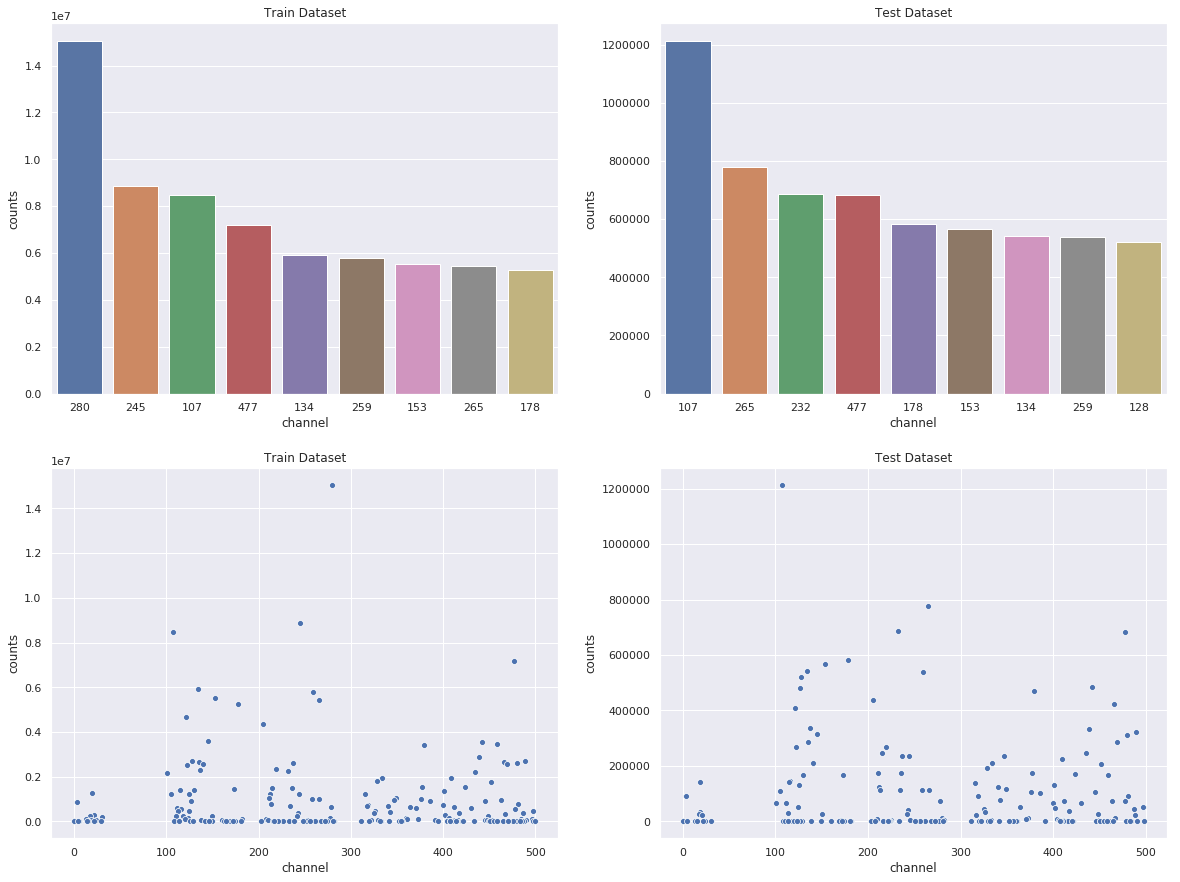

In [0]:
#creating plots for channel
channel_train_10, channel_test_10, channel_train, channel_test = create_value_counts(train_all, test_all, 'channel')
create_plots(channel_train_10, channel_test_10, channel_train, channel_test)

The distributions between the training and test datasets look similar but the top 10 are completely different.

/usr/local/lib/python3.6/dist-packages/dask/core.py:118: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/usr/local/lib/python3.6/dist-packages/dask/core.py:118: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


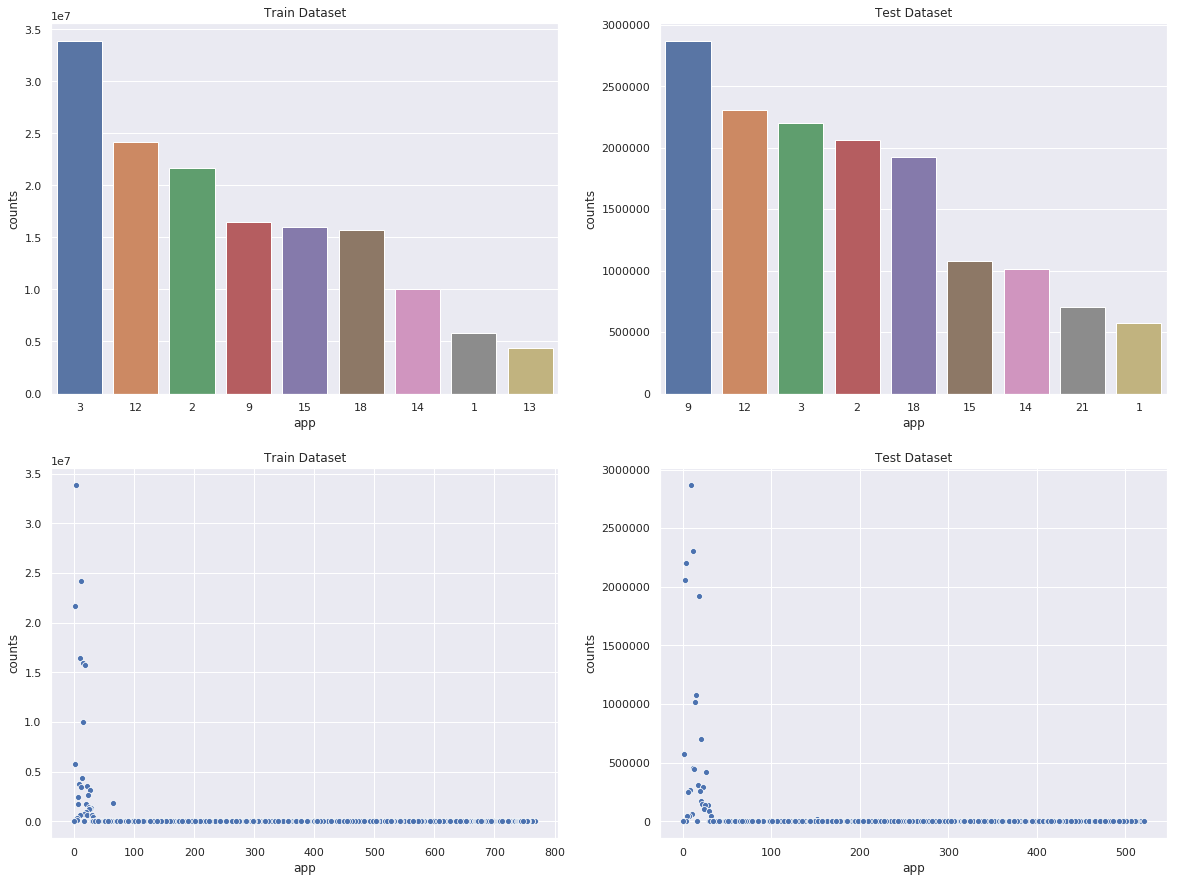

In [0]:
#creating plots for app
app_train_10, app_test_10, app_train, app_test = create_value_counts(train_all, test_all, 'app')
create_plots(app_train_10, app_test_10, app_train, app_test)

App looks similar in the 

In [0]:
del channel_train_10, channel_test_10, channel_train, channel_test
gc.collect() 

<function gc.collect>

/usr/local/lib/python3.6/dist-packages/dask/core.py:118: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]
/usr/local/lib/python3.6/dist-packages/dask/core.py:118: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


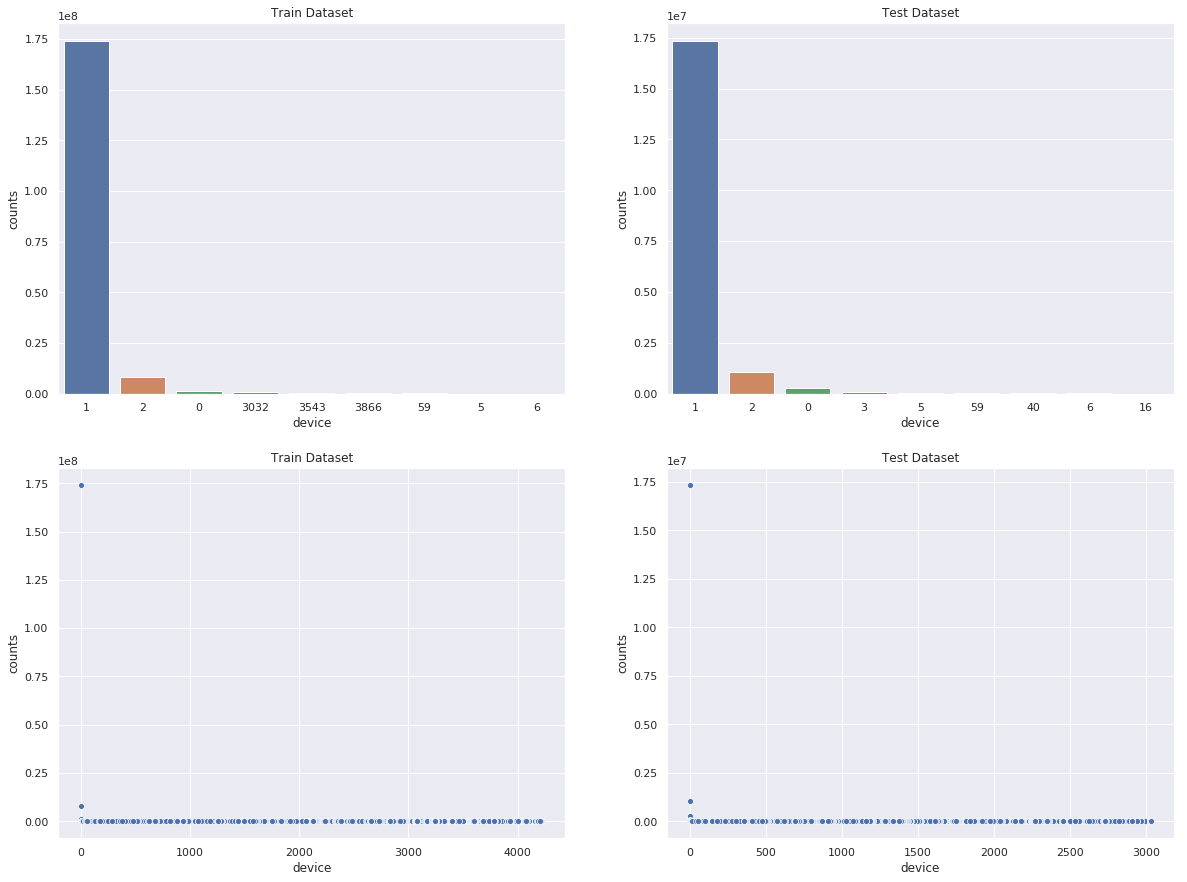

In [0]:
#creating plots for device
device_train_10, device_test_10, device_train, device_test = create_value_counts(train_all, test_all, 'device')
create_plots(device_train_10, device_test_10, device_train, device_test)

Device looks the same in both datasets. Again, there isn't a lot of variability here. Might drop this feature altogether.

In [0]:
del device_train_10, device_test_10, device_train, device_test
gc.collect()

10131

# is_attributed click counts and distributions

In this section, the plots show only data for is_attributed==1 clicks. The plots on the left have total click counts on the y-axis and the feature on the x-axis. The plots on the right have index on the x-axis and feature on the y-axis. Since rows in the dataframe are ordered by time, want to see plots of features across time.

In [0]:
is_attributed=train_all.loc[train_all['is_attributed']==1, ['ip', 'os', 'channel', 'device', 'app']]
is_attributed=is_attributed.compute()

def is_attributed_plots(data, var):
  var_counts = data[var].value_counts()
  var_counts = var_counts.reset_index(name='counts')
  var_counts.columns = [var, 'counts']
  fig, axs = plt.subplots(ncols=2, figsize=(25,10))
  sns.scatterplot(x=var, y='counts', ax=axs[0], data=var_counts).set_title(var+' is_attributed value_counts')
  sns.scatterplot(x=data.index, y=var, ax=axs[1], data=data).set_title(var+' is_attributed distribution')

/usr/local/lib/python3.6/dist-packages/dask/core.py:118: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


4529

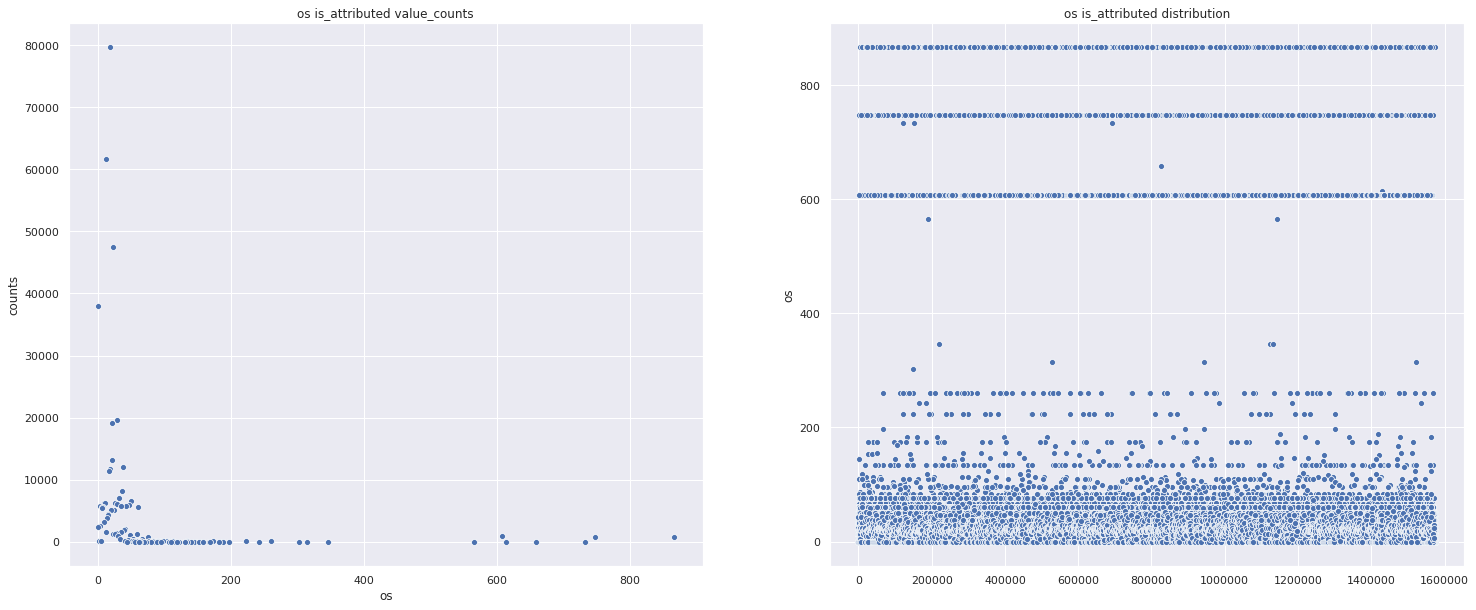

In [0]:
is_attributed_plots(is_attributed, 'os')
gc.collect()

4531

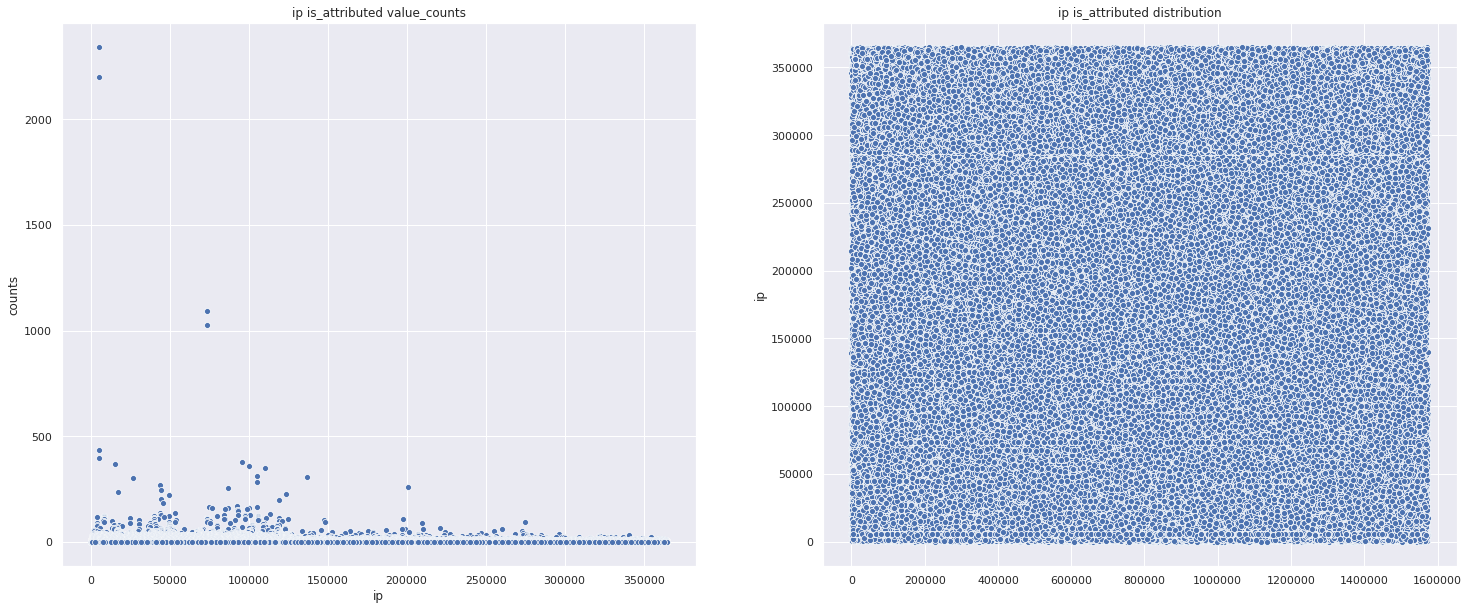

In [0]:
is_attributed_plots(is_attributed, 'ip')
gc.collect()

We can  see the trend of higher clicks at lower ip addresses in the is_attributed clicks 

In [0]:
We can see

4618

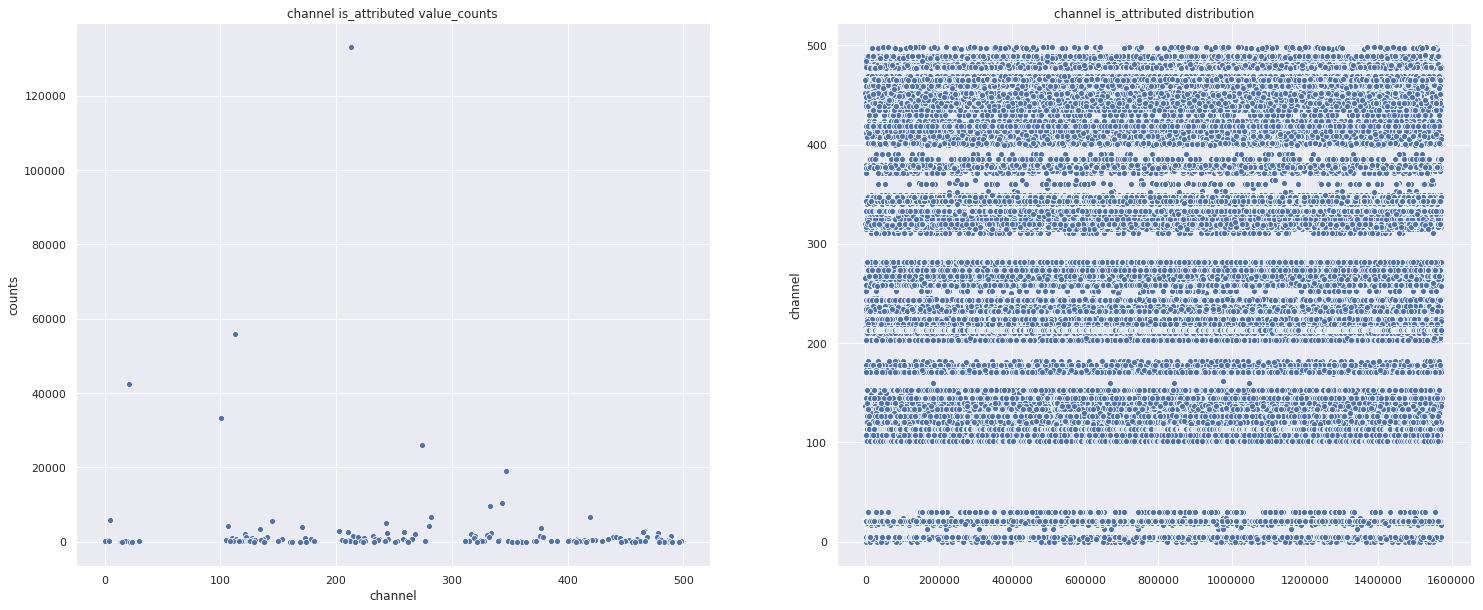

In [0]:
is_attributed_plots(is_attributed, 'channel')
gc.collect()

There is one channel that has a noticeably high click count. Wondering if we could see this same trend in the not_attributed. 

4477

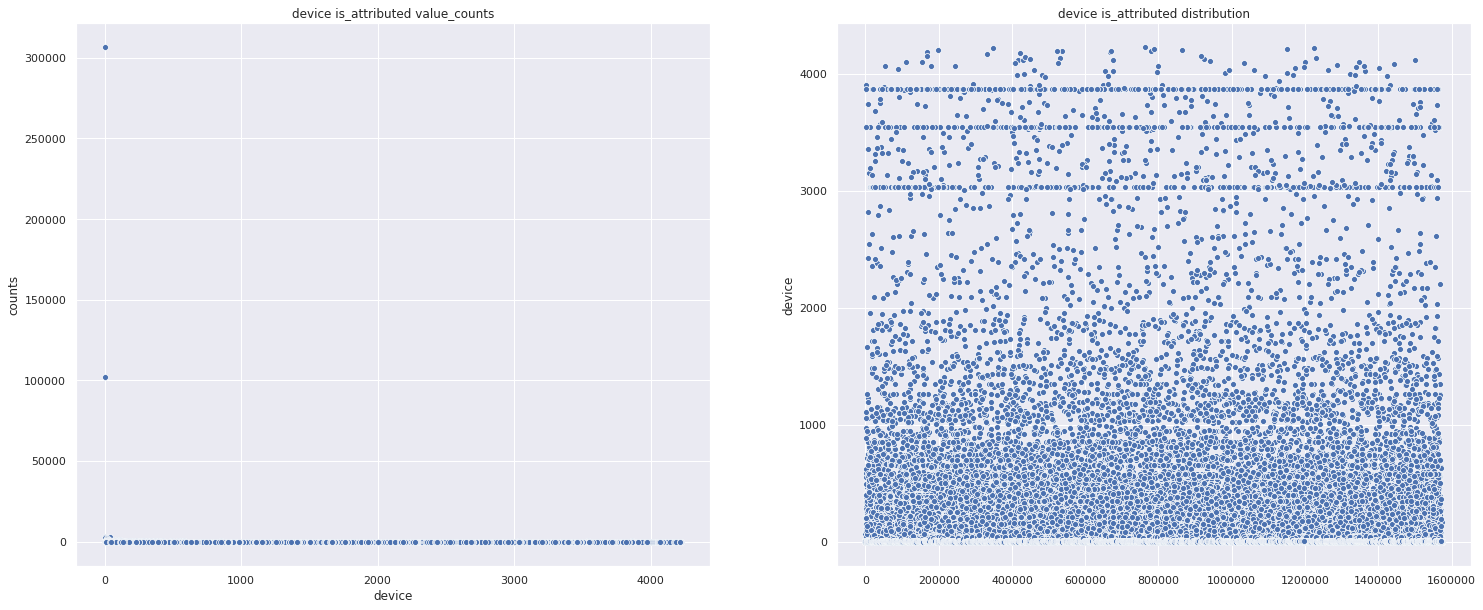

In [0]:
is_attributed_plots(is_attributed, 'device')
gc.collect()

20157

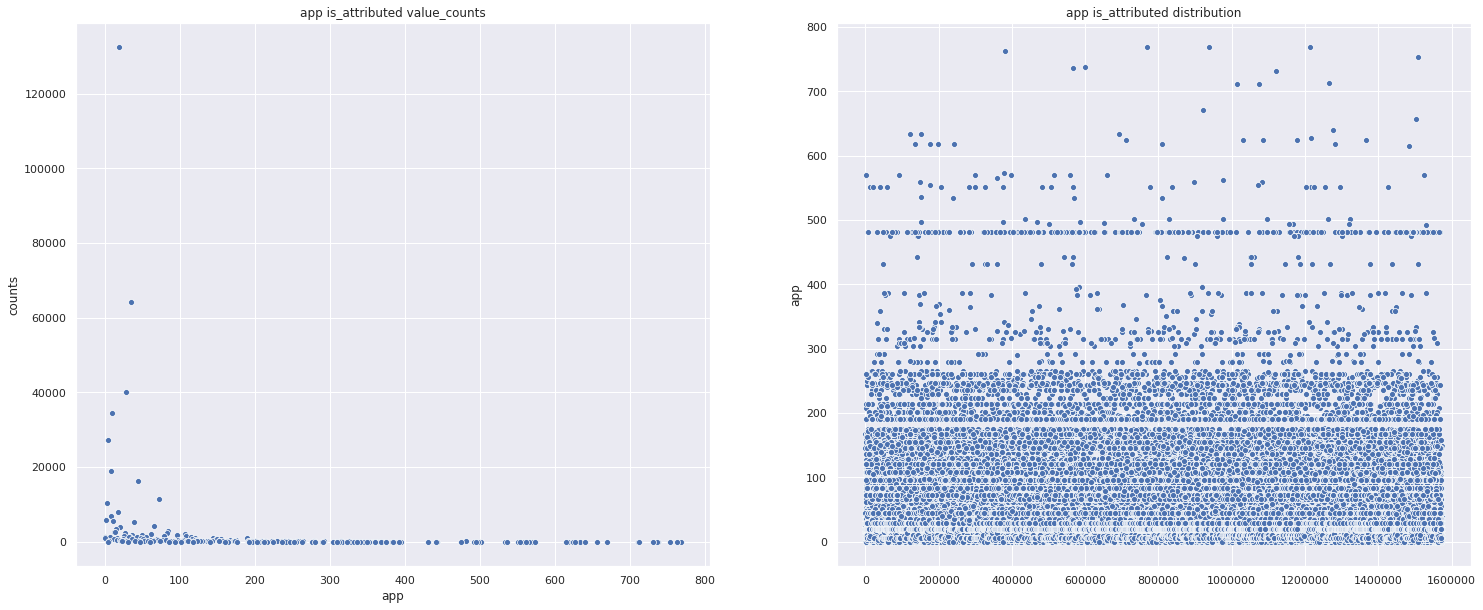

In [0]:
is_attributed_plots(is_attributed, 'app')
gc.collect()

# is_attributed vs not attributed distributions

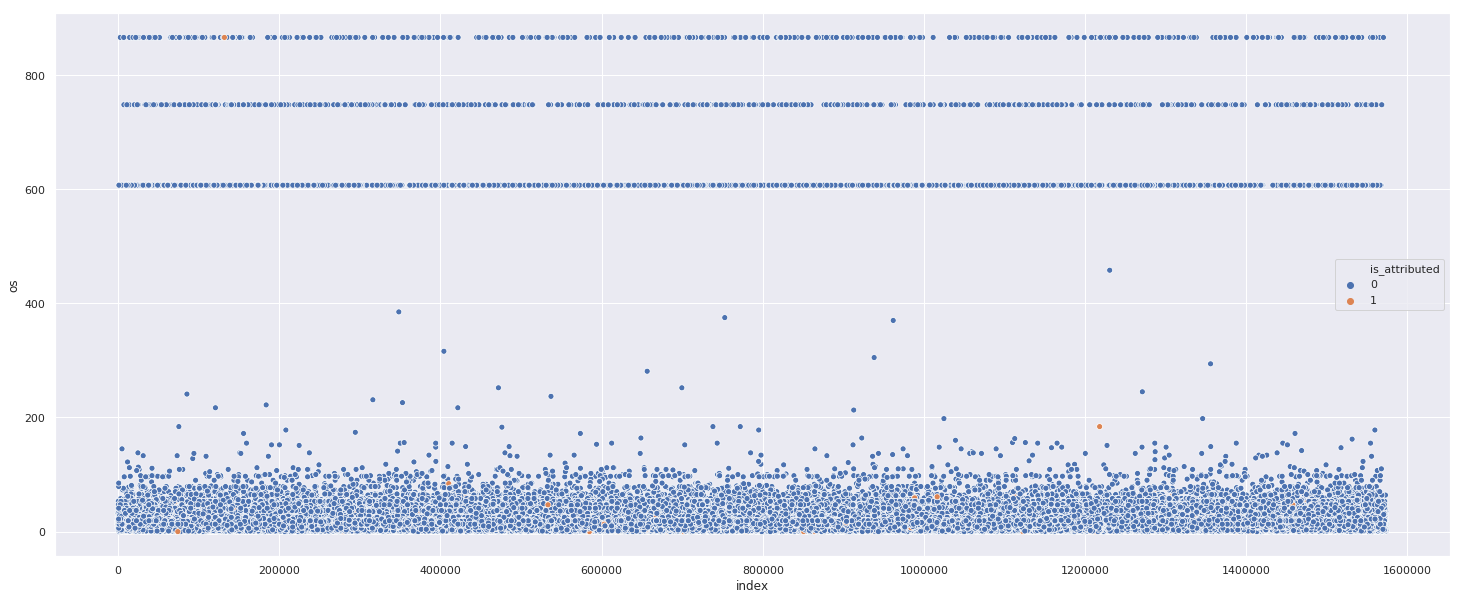

In [0]:
train_sample=train_all[['os', 'is_attributed']].sample(0.002).compute()
fig, ax = plt.subplots(figsize=(25,10))
sns.scatterplot(x='index', y='os', data=train_sample, hue='is_attributed')

/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:1092: UserWarning: sample does not support the number of sampled items parameter, 'n'. Please use the 'frac' parameter instead.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/dask/core.py:118: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


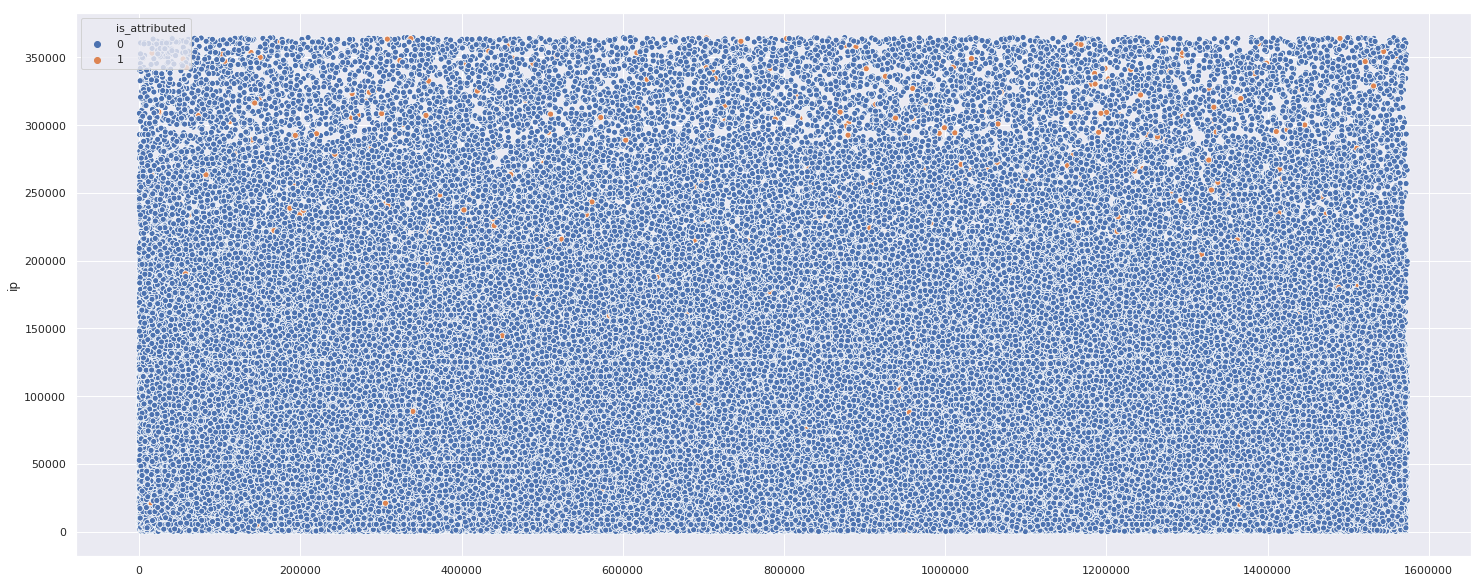

In [0]:
train_sample=train_all[['ip', 'is_attributed']].sample(0.002).compute()
fig, ax = plt.subplots(figsize=(25,10))
sns.scatterplot(x=train_sample.index, y='ip', data=train_sample, hue='is_attributed')

It looks like there were more downloads at higher ip's  but I think this is possibly because ip's with higher click counts were assigned lower ip numeric values. The orange is likely covered up more at the lower ips.  

/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:1092: UserWarning: sample does not support the number of sampled items parameter, 'n'. Please use the 'frac' parameter instead.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/dask/core.py:118: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


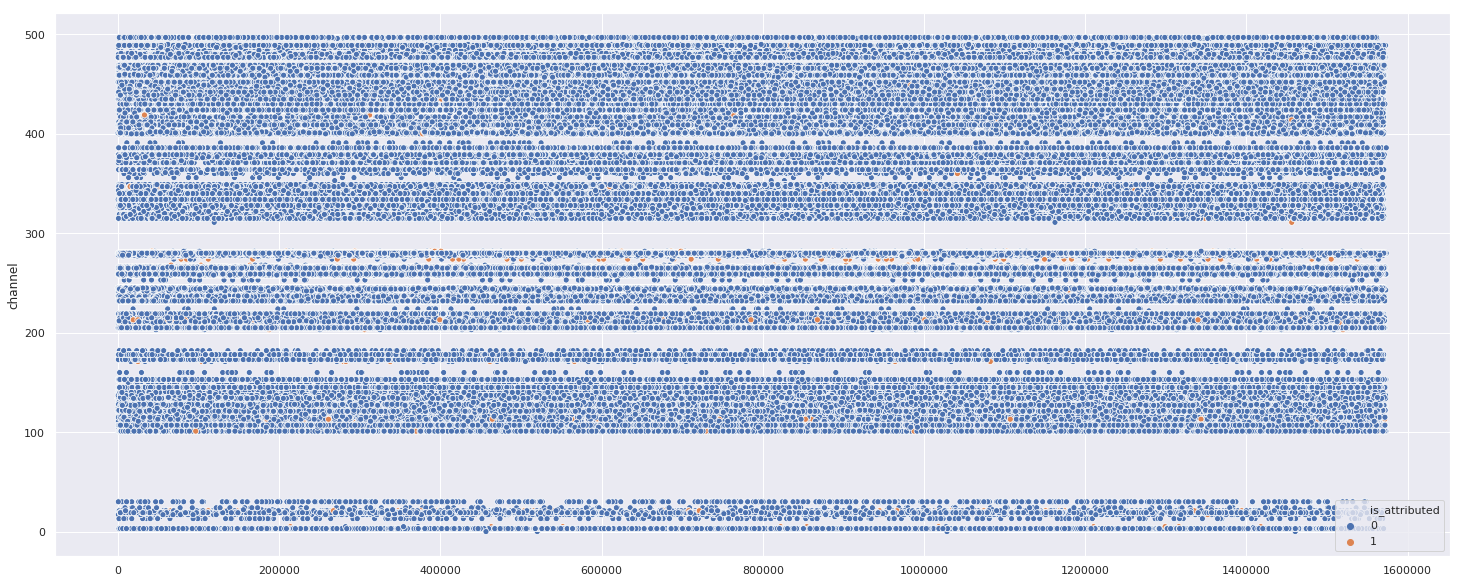

In [0]:
train_sample=train_all[['channel', 'is_attributed']].sample(0.002).compute()
fig, ax = plt.subplots(figsize=(25,10))
sns.scatterplot(x=train_sample.index, y='channel', data=train_sample, hue='is_attributed')

I see the most striking patterns for differences in is_attributed and not attributed with channel. There's a stripe of orange for a channel in between 200 and 300. There's less orange dots at higher channels even though it looks like there's a higher volume of clicks. 

/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:1092: UserWarning: sample does not support the number of sampled items parameter, 'n'. Please use the 'frac' parameter instead.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/dask/core.py:118: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


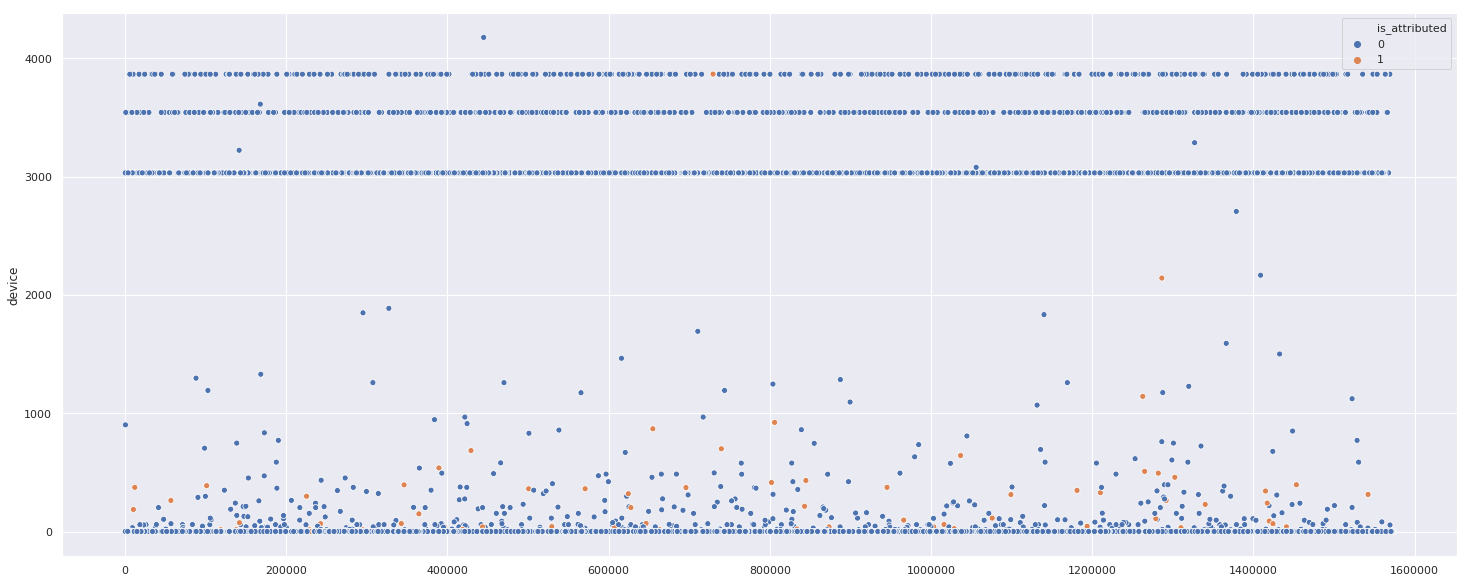

In [0]:
train_sample=train_all[['device', 'is_attributed']].sample(0.002).compute()
fig, ax = plt.subplots(figsize=(25,10))
sns.scatterplot(x=train_sample.index, y='device', data=train_sample, hue='is_attributed')

Device is hard to see a signal since a huge majority of people only use 2 devices for both not attributed and is attributed. Given the huge difference in volume of clicks between not downloaded and is downloaded, there does seem to be a relatively high number of downloads for device id's between 100-1000.

/usr/local/lib/python3.6/dist-packages/dask/dataframe/core.py:1092: UserWarning: sample does not support the number of sampled items parameter, 'n'. Please use the 'frac' parameter instead.
  warnings.warn(msg)
/usr/local/lib/python3.6/dist-packages/dask/core.py:118: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  args2 = [_execute_task(a, cache) for a in args]


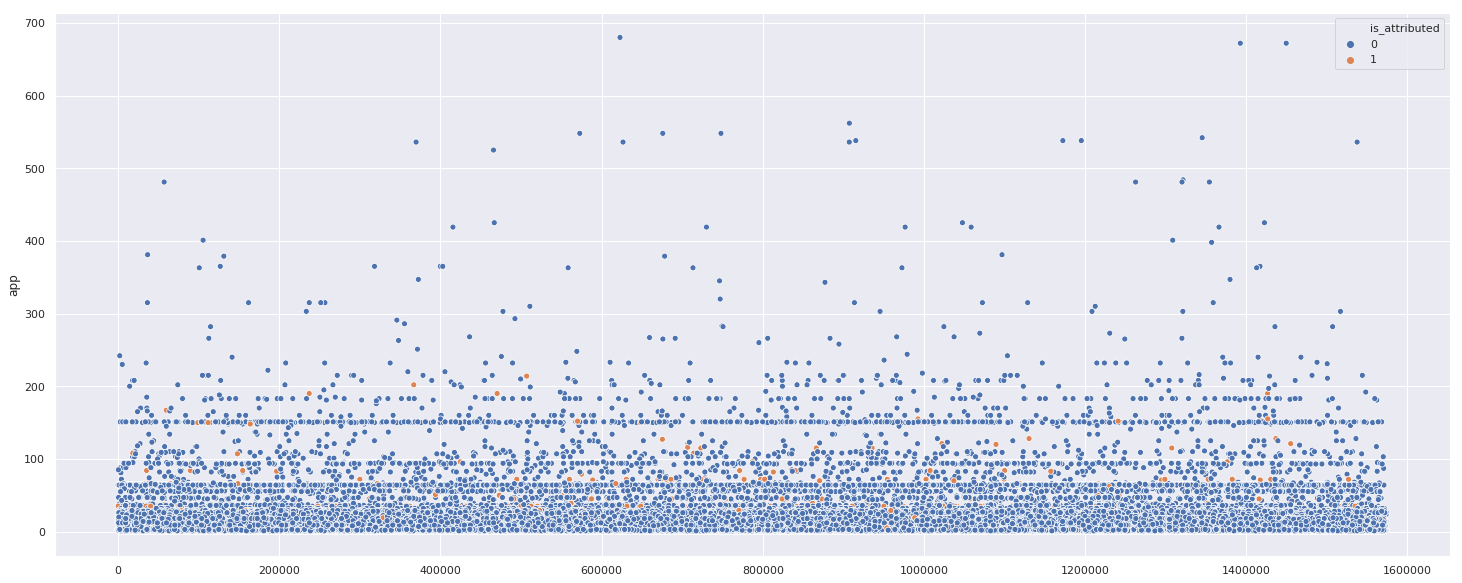

In [0]:
train_sample=train_all[['app', 'is_attributed']].sample(0.002).compute()
fig, ax = plt.subplots(figsize=(25,10))
sns.scatterplot(x=train_sample.index, y='app', data=train_sample, hue='is_attributed')

In [0]:
Again, it seems like there's more downloads at higher app ids but i think it's possible there are just many more clicks at lower app id's.